In [ ]:
!pip install xgboost ta --quiet

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')
datapath = "/content/drive/My Drive/ise364"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(os.path.join(datapath,'AAPL_10y_OHLCV.csv'))

In [ ]:
df = df.drop(index=[0, 1, 2]).reset_index(drop=True)
df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
num_cols = ["Close", "High", "Low", "Open", "Volume"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Clean and set index
df = df.dropna().sort_values("Date").set_index("Date")
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq("D").fillna(method="ffill").dropna()

df["MA7"] = df["Close"].rolling(7).mean()
df["MA30"] = df["Close"].rolling(30).mean()
df["Return"] = df["Close"].pct_change()

df = df.dropna()

print(f"Data loaded. Shape: {df.shape}")

Data loaded. Shape: (3623, 8)


In [ ]:
df.head()

,Close,High,Low,Open,Volume,MA7,MA30,Return
Date,,,,,,,,
2016-01-08,21.861465,22.346224,21.816372,22.219962,283192000.0,22.955636,24.188835,0.005288
2016-01-09,21.861465,22.346224,21.816372,22.219962,283192000.0,22.688294,24.044460,0.000000
2016-01-10,21.861465,22.346224,21.816372,22.219962,283192000.0,22.420951,23.922556,0.000000
2016-01-11,22.215456,22.334954,21.947147,22.314663,198957600.0,22.201280,23.812452,0.016192
2016-01-12,22.537868,22.702462,22.285343,22.670896,196616800.0,22.112702,23.713095,0.014513


In [ ]:
# Basic price features
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Simple moving averages
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_30'] = df['Close'].rolling(30).mean()
df['SMA_40'] = df['Close'].rolling(40).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_60'] = df['Close'].rolling(60).mean()
df['SMA_70'] = df['Close'].rolling(70).mean()
df['SMA_80'] = df['Close'].rolling(80).mean()
df['SMA_90'] = df['Close'].rolling(90).mean()
df['SMA_100'] = df['Close'].rolling(100).mean()

# EMA for MACD
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']

#Add RSI (Relative Strength Index)
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["RSI"] = compute_rsi(df["Close"])

#Add Bollinger Bands (Volatility Indicator)
df["BB_Middle"] = df["Close"].rolling(window=20).mean()
df["BB_Std"] = df["Close"].rolling(window=20).std()
df["BB_Upper"] = df["BB_Middle"] + (df["BB_Std"] * 2)
df["BB_Lower"] = df["BB_Middle"] - (df["BB_Std"] * 2)

# Lag features
for lag in [1, 2, 3, 4, 5, 6, 7, 8]:
    df[f'Lag_{lag}'] = df['Close'].shift(lag)
    df[f'Return_Lag_{lag}'] = df['Return'].shift(lag)

# Targets
df['Close_Tomorrow'] = df['Close'].shift(-1)
df['Direction'] = (df['Close_Tomorrow'] > df['Close']).astype(int)

# Remove NaN rows
df = df.dropna()
print(f"{df.shape}")

(3523, 45)


In [ ]:
df.head()

,Close,High,Low,Open,Volume,MA7,MA30,Return,Log_Return,SMA_10,...,Lag_5,Return_Lag_5,Lag_6,Return_Lag_6,Lag_7,Return_Lag_7,Lag_8,Return_Lag_8,Close_Tomorrow,Direction
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-16,24.902157,25.457554,24.874955,25.414482,187756000.0,24.999635,24.560608,0.000000,0.000000,24.886743,...,24.713997,0.003313,24.632397,0.000000,24.632397,0.000000,24.632397,0.001106,24.902157,0
2016-04-17,24.902157,25.457554,24.874955,25.414482,187756000.0,25.038172,24.590305,0.000000,0.000000,24.916440,...,25.035910,0.013026,24.713997,0.003313,24.632397,0.000000,24.632397,0.000000,24.364895,0
2016-04-18,24.364895,24.698131,24.242481,24.684530,243286000.0,24.988301,24.602093,-0.021575,-0.021811,24.889689,...,25.398613,0.014487,25.035910,0.013026,24.713997,0.003313,24.632397,0.000000,24.235689,0
2016-04-19,24.235689,24.482783,24.081538,24.455579,129539600.0,24.873983,24.609574,-0.005303,-0.005317,24.850019,...,25.412216,0.000536,25.398613,0.014487,25.035910,0.013026,24.713997,0.003313,24.285553,1
2016-04-20,24.285553,24.503177,24.042992,24.174474,122444000.0,24.714975,24.618792,0.002057,0.002055,24.815334,...,24.902157,-0.020071,25.412216,0.000536,25.398613,0.014487,25.035910,0.013026,24.022596,0


In [ ]:
feature_list = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_10', 'SMA_50', 'SMA_100',
    'MACD', 'RSI', 'BB_Middle',
    'Lag_1', 'Lag_2', 'Lag_3',
    'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3'
]

available_features = [f for f in feature_list if f in df.columns]
X = df[available_features]

print(f"Selected {len(available_features)} features")
print("Features:", available_features)

Selected 17 features
Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_50', 'SMA_100', 'MACD', 'RSI', 'BB_Middle', 'Lag_1', 'Lag_2', 'Lag_3', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3']


In [ ]:
y_direction = df['Direction']  # For classification
y_tomorrow = df['Close_Tomorrow']  # For regression

# Train-test split
split_idx = int(len(X) * 0.9)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train_clf = y_direction.iloc[:split_idx]
y_test_clf = y_direction.iloc[split_idx:]
y_train_reg = y_tomorrow.iloc[:split_idx]
y_test_reg = y_tomorrow.iloc[split_idx:]

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (3170, 17)
Test size: (353, 17)


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
clf_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    early_stopping_rounds=10
)

clf_model.fit(
    X_train_scaled, y_train_clf,
    eval_set=[(X_test_scaled, y_test_clf)],
    verbose=False
)

y_clf_pred = clf_model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test_clf, y_clf_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_clf, y_clf_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_clf_pred))

Accuracy: 0.6516

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.93      0.78       227
           1       0.55      0.14      0.23       126

    accuracy                           0.65       353
   macro avg       0.60      0.54      0.50       353
weighted avg       0.62      0.65      0.58       353


Confusion Matrix:
[[212  15]
 [108  18]]


In [ ]:
reg_model = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

reg_model.fit(
    X_train_scaled, y_train_reg,
    eval_set=[(X_test_scaled, y_test_reg)],
    verbose=False
)

y_reg_pred = reg_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_reg, y_reg_pred))
mae = mean_absolute_error(y_test_reg, y_reg_pred)
r2 = r2_score(y_test_reg, y_reg_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 11.56
MAE: 7.44
R²: 0.7860


In [ ]:
# Classification feature importance
# shows which features are most influential in predicting the direction of the stock price
clf_importances = clf_model.feature_importances_
clf_feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf_importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features for Classification:")
print(clf_feat_importance.head(10))

# Regression feature importance
# indicates which features are most influential in predicting the actual continuous value of the stock price
reg_importances = reg_model.feature_importances_
reg_feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': reg_importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features for Regression:")
print(reg_feat_importance.head(10))


Top 10 Features for Classification:
         Feature  Importance
14  Return_Lag_1    0.146378
16  Return_Lag_3    0.142281
15  Return_Lag_2    0.110095
1           High    0.051937
11         Lag_1    0.048836
0           Open    0.048029
7        SMA_100    0.047875
12         Lag_2    0.046092
2            Low    0.045179
13         Lag_3    0.045178

Top 10 Features for Regression:
    Feature  Importance
13    Lag_3    0.357415
11    Lag_1    0.211746
3     Close    0.188515
1      High    0.071368
2       Low    0.062130
0      Open    0.056157
5    SMA_10    0.030834
6    SMA_50    0.010271
12    Lag_2    0.008308
7   SMA_100    0.002255


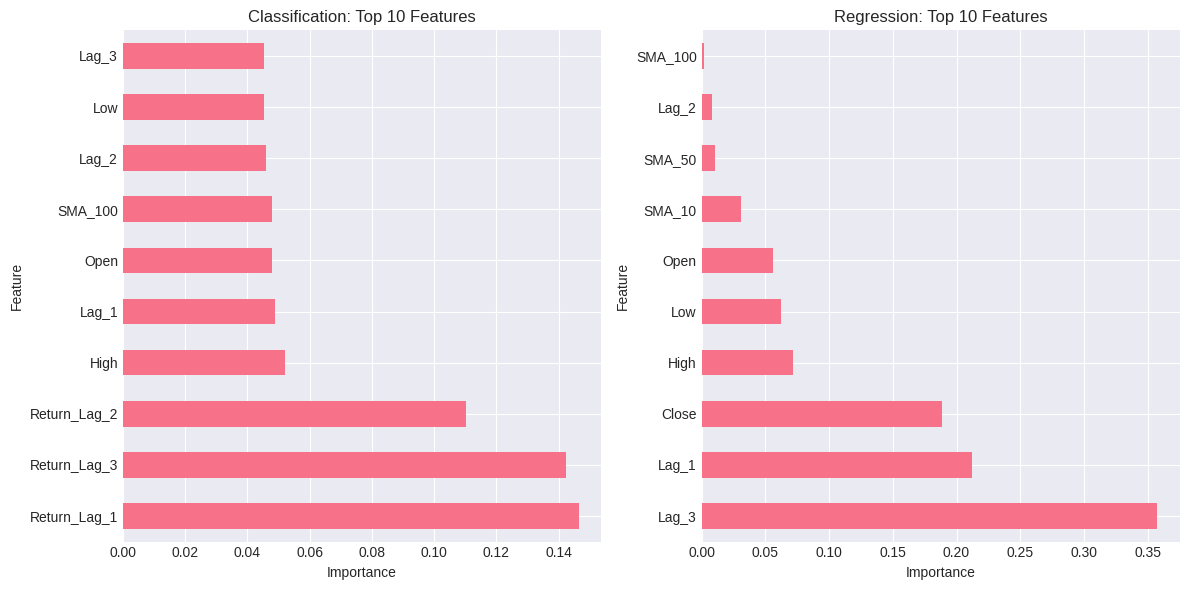

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

#Feature Importance Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
clf_feat_importance.head(10).set_index('Feature')['Importance'].plot(kind='barh')
plt.title('Classification: Top 10 Features')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
reg_feat_importance.head(10).set_index('Feature')['Importance'].plot(kind='barh')
plt.title('Regression: Top 10 Features')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

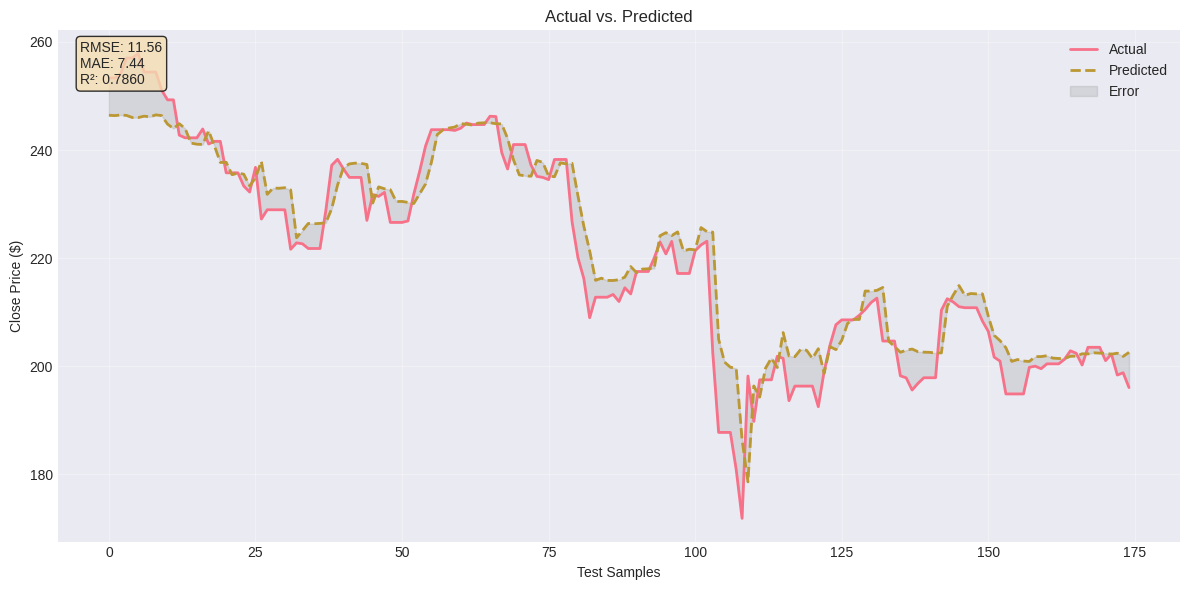

In [ ]:
#Actual vs. Predicted Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_reg.values[:175], label='Actual', linewidth=2)
plt.plot(y_reg_pred[:175], label='Predicted', linestyle='--', linewidth=2)
plt.fill_between(range(175),
                 y_test_reg.values[:175],
                 y_reg_pred[:175],
                 alpha=0.2, color='gray', label='Error')
plt.xlabel('Test Samples')
plt.ylabel('Close Price ($)')
plt.title('Actual vs. Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

# Add metrics box
metrics_text = f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.4f}"
plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()